# Statsmodels Tutorial Notebook

This notebook explores Statsmodels for machine learning tasks, including data preprocessing, model training, evaluation, and diagnostics using the Chicago Taxi dataset for regression.

## 1. Import Required Libraries

Import Statsmodels, NumPy, Pandas, and other necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## 2. Load and Explore Dataset

Load the Chicago Taxi dataset and perform comprehensive exploration to understand the data structure, identify potential features and targets, and make informed feature selection decisions.

In [2]:
# Load the Chicago Taxi dataset
df = pd.read_csv('../dataset/chicago_taxi_train.csv')

print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (31694, 18)

Column names:
['TRIP_START_TIMESTAMP', 'TRIP_END_TIMESTAMP', 'TRIP_START_HOUR', 'TRIP_SECONDS', 'TRIP_MILES', 'TRIP_SPEED', 'PICKUP_CENSUS_TRACT', 'DROPOFF_CENSUS_TRACT', 'PICKUP_COMMUNITY_AREA', 'DROPOFF_COMMUNITY_AREA', 'FARE', 'TIPS', 'TIP_RATE', 'TOLLS', 'EXTRAS', 'TRIP_TOTAL', 'PAYMENT_TYPE', 'COMPANY']

Data types:
TRIP_START_TIMESTAMP       object
TRIP_END_TIMESTAMP         object
TRIP_START_HOUR           float64
TRIP_SECONDS                int64
TRIP_MILES                float64
TRIP_SPEED                float64
PICKUP_CENSUS_TRACT       float64
DROPOFF_CENSUS_TRACT      float64
PICKUP_COMMUNITY_AREA     float64
DROPOFF_COMMUNITY_AREA    float64
FARE                      float64
TIPS                      float64
TIP_RATE                  float64
TOLLS                     float64
EXTRAS                    float64
TRIP_TOTAL                float64
PAYMENT_TYPE               object
COMPANY                    object
dtype: object

First 5 rows:
    TRIP

In [3]:
# Check for missing values and data quality
print("Missing values per column:")
print(df.isnull().sum())
print("\nBasic statistics for numerical columns:")
numerical_cols = df.select_dtypes(include=[np.number]).columns
print(df[numerical_cols].describe())

Missing values per column:
TRIP_START_TIMESTAMP          0
TRIP_END_TIMESTAMP            0
TRIP_START_HOUR               0
TRIP_SECONDS                  0
TRIP_MILES                    0
TRIP_SPEED                    0
PICKUP_CENSUS_TRACT       18435
DROPOFF_CENSUS_TRACT      17671
PICKUP_COMMUNITY_AREA      3217
DROPOFF_COMMUNITY_AREA     3495
FARE                          0
TIPS                          0
TIP_RATE                      0
TOLLS                         0
EXTRAS                        0
TRIP_TOTAL                    0
PAYMENT_TYPE                  0
COMPANY                       0
dtype: int64

Basic statistics for numerical columns:
       TRIP_START_HOUR  TRIP_SECONDS    TRIP_MILES    TRIP_SPEED  \
count     31694.000000  31694.000000  31694.000000  31694.000000   
mean         14.185635   1319.796397      8.289463     20.256544   
std           5.159454    928.932873      7.265672     11.110390   
min           0.000000     60.000000      0.500000      4.000000   
25%

In [4]:
# Analyze potential target variables for regression
potential_targets = ['FARE', 'TRIP_TOTAL', 'TIPS', 'TIP_RATE']
print("Potential target variables analysis:")
for target in potential_targets:
    if target in df.columns:
        print(f"\n{target}:")
        print(f"  Range: {df[target].min():.2f} to {df[target].max():.2f}")
        print(f"  Mean: {df[target].mean():.2f}")
        print(f"  Missing values: {df[target].isnull().sum()}")
        print(f"  Non-zero values: {(df[target] > 0).sum()}")

Potential target variables analysis:

FARE:
  Range: 3.25 to 159.25
  Mean: 23.91
  Missing values: 0
  Non-zero values: 31694

TRIP_TOTAL:
  Range: 3.25 to 248.50
  Mean: 29.76
  Missing values: 0
  Non-zero values: 31694

TIPS:
  Range: 0.00 to 60.00
  Mean: 3.25
  Missing values: 0
  Non-zero values: 17407

TIP_RATE:
  Range: 0.00 to 648.60
  Mean: 12.97
  Missing values: 0
  Non-zero values: 17403


In [5]:
# Analyze potential features for regression
potential_features = ['TRIP_MILES', 'TRIP_SECONDS', 'TRIP_START_HOUR', 'TRIP_SPEED', 
                     'PICKUP_COMMUNITY_AREA', 'DROPOFF_COMMUNITY_AREA']
print("Potential features analysis:")
for feature in potential_features:
    if feature in df.columns:
        print(f"\n{feature}:")
        if df[feature].dtype in ['int64', 'float64']:
            print(f"  Range: {df[feature].min()} to {df[feature].max()}")
            print(f"  Mean: {df[feature].mean():.2f}")
        print(f"  Missing values: {df[feature].isnull().sum()}")
        print(f"  Unique values: {df[feature].nunique()}")

Potential features analysis:

TRIP_MILES:
  Range: 0.5 to 68.12
  Mean: 8.29
  Missing values: 0
  Unique values: 2602

TRIP_SECONDS:
  Range: 60 to 7140
  Mean: 1319.80
  Missing values: 0
  Unique values: 3740

TRIP_START_HOUR:
  Range: 0.0 to 23.75
  Mean: 14.19
  Missing values: 0
  Unique values: 96

TRIP_SPEED:
  Range: 4.0 to 64.8
  Mean: 20.26
  Missing values: 0
  Unique values: 569

PICKUP_COMMUNITY_AREA:
  Range: 1.0 to 77.0
  Mean: 35.56
  Missing values: 3217
  Unique values: 77

DROPOFF_COMMUNITY_AREA:
  Range: 1.0 to 77.0
  Mean: 25.55
  Missing values: 3495
  Unique values: 77


In [6]:
# Make informed feature and target selection based on analysis
# Select FARE as target (most fundamental pricing metric)
# Select TRIP_MILES as primary feature (strongest predictor of fare)
# Clean data by removing missing values
df_clean = df.dropna(subset=['TRIP_MILES', 'FARE'])
df_clean = df_clean[(df_clean['TRIP_MILES'] > 0) & (df_clean['FARE'] > 0)]

X = df_clean['TRIP_MILES']
y = df_clean['FARE']

print(f"Selected feature: TRIP_MILES")
print(f"Selected target: FARE")
print(f"Clean dataset shape: {df_clean.shape}")
print(f"\nFeature statistics:")
print(f"  TRIP_MILES - Mean: {X.mean():.2f}, Std: {X.std():.2f}")
print(f"  FARE - Mean: {y.mean():.2f}, Std: {y.std():.2f}")
print(f"\nCorrelation between TRIP_MILES and FARE: {X.corr(y):.3f}")

Selected feature: TRIP_MILES
Selected target: FARE
Clean dataset shape: (31694, 18)

Feature statistics:
  TRIP_MILES - Mean: 8.29, Std: 7.27
  FARE - Mean: 23.91, Std: 16.97

Correlation between TRIP_MILES and FARE: 0.975


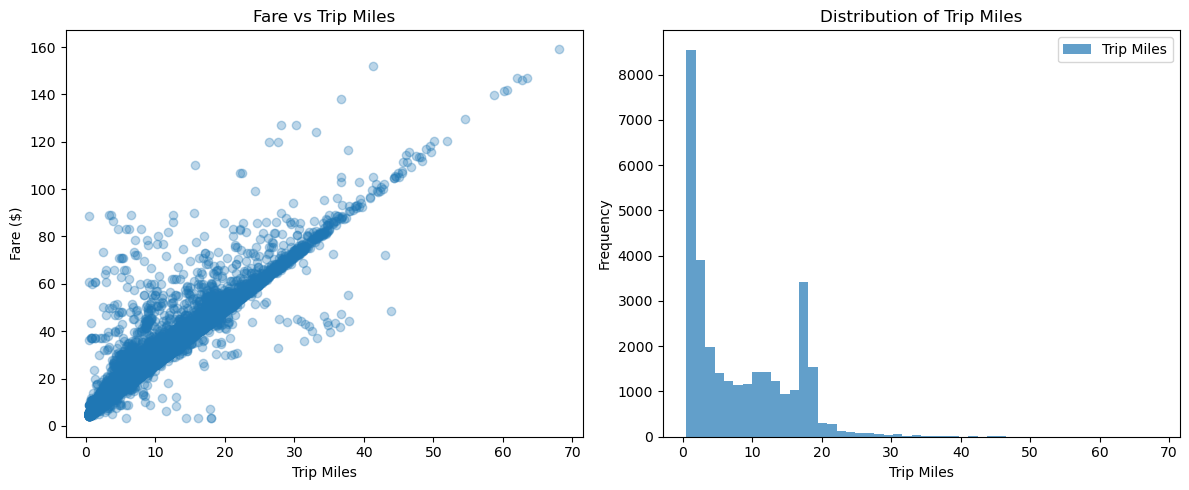

In [7]:
# Visualize the relationship between selected feature and target
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot
axes[0].scatter(X, y, alpha=0.3)
axes[0].set_xlabel('Trip Miles')
axes[0].set_ylabel('Fare ($)')
axes[0].set_title('Fare vs Trip Miles')

# Distribution plots
axes[1].hist(X, bins=50, alpha=0.7, label='Trip Miles')
axes[1].set_xlabel('Trip Miles')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Trip Miles')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Preprocess Data

Apply preprocessing techniques including adding constant term for Statsmodels and handling any remaining data quality issues.

In [8]:
# Add constant term required by Statsmodels for intercept
X_with_constant = sm.add_constant(X)

print("Shape after adding constant:", X_with_constant.shape)
print("\nFirst 5 rows with constant:")
print(X_with_constant.head())

Shape after adding constant: (31694, 2)

First 5 rows with constant:
   const  TRIP_MILES
0    1.0        2.57
1    1.0        1.18
2    1.0        1.29
3    1.0        3.70
4    1.0        1.15


## 4. Split Data into Training and Testing Sets

Use train_test_split to divide the data into training and testing sets.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_with_constant, y, test_size=0.2, random_state=0)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print(f"Training samples: {len(y_train)}")
print(f"Testing samples: {len(y_test)}")

Training set shape: (25355, 2)
Testing set shape: (6339, 2)
Training samples: 25355
Testing samples: 6339


## 5. Train a Machine Learning Model

Select and train an OLS regression model from Statsmodels.

In [10]:
model = sm.OLS(y_train, X_train).fit()

print("Model trained successfully!")
print(model.summary())

Model trained successfully!
                            OLS Regression Results                            
Dep. Variable:                   FARE   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 4.995e+05
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        00:46:56   Log-Likelihood:                -69354.
No. Observations:               25355   AIC:                         1.387e+05
Df Residuals:                   25353   BIC:                         1.387e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0281   

## 6. Make Predictions

Use the trained model to make predictions on the test set.

In [11]:
# Use the model to make predictions on the test set.
y_pred = model.predict(X_test)

print("Predictions:", y_pred[:10])  # Show first 10 predictions
print("Actual values:", y_test[:10])

Predictions: 14653    27.449505
23435    32.690287
24202    30.776262
13344    23.735385
6226      9.425771
1190      6.691450
15616    17.150228
18221    26.401348
5110      7.785179
4449      9.289055
dtype: float64
Actual values: 14653    29.50
23435    33.00
24202    29.75
13344    24.25
6226      9.25
1190      9.18
15616    17.00
18221    27.00
5110      6.75
4449      9.50
Name: FARE, dtype: float64


## 7. Evaluate Model Performance

Calculate regression metrics like MSE and R² to evaluate the model.

In [12]:
# Evaluate the model's performance on the test set using metrics like Mean Squared Error (MSE) and R-squared.

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 14.477537112737577
R^2 Score: 0.9497058070457518


## 8. Residual Normality Diagnostics

Perform residual normality diagnostics using histograms, Q-Q plots, and Jarque-Bera test.

/Users/jefflee/Applications/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jefflee/Applications/anaconda3/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Jarque–Bera: stat=15208683.70, p-value=0.00000, skew=7.132, kurtosis=122.132


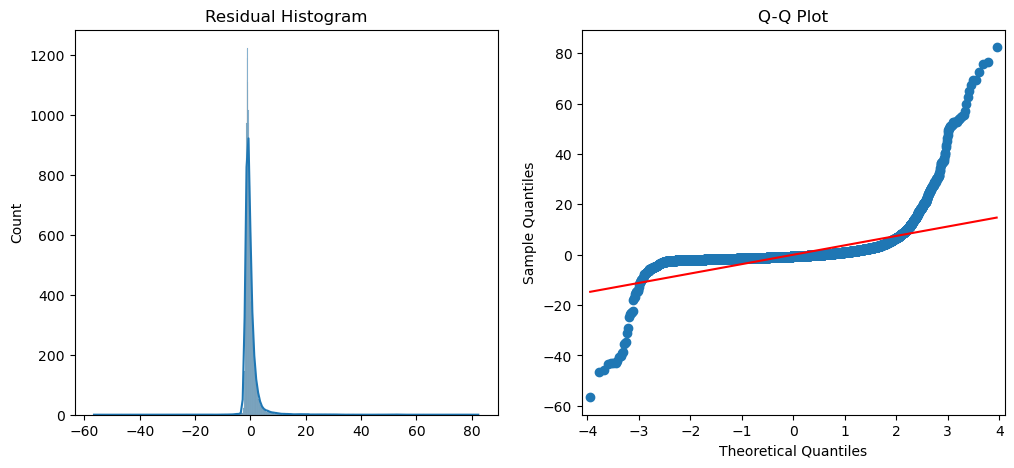

In [13]:
residuals = model.resid
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(residuals, kde=True, ax=ax[0])
ax[0].set_title('Residual Histogram')
qqplot(residuals, line='s', ax=ax[1])
ax[1].set_title('Q-Q Plot')

jb_stat, jb_pvalue, skew, kurt = jarque_bera(residuals)
print(f"Jarque–Bera: stat={jb_stat:.2f}, p-value={jb_pvalue:.5f}, skew={skew:.3f}, kurtosis={kurt:.3f}")

## 9. Heteroscedasticity Test & Robust Standard Errors

Conduct heteroscedasticity test using Breusch-Pagan and apply robust standard errors.

Breusch–Pagan p-value: 0.00000
                            OLS Regression Results                            
Dep. Variable:                   FARE   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 2.329e+05
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        00:47:27   Log-Likelihood:                -69354.
No. Observations:               25355   AIC:                         1.387e+05
Df Residuals:                   25353   BIC:                         1.387e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0281

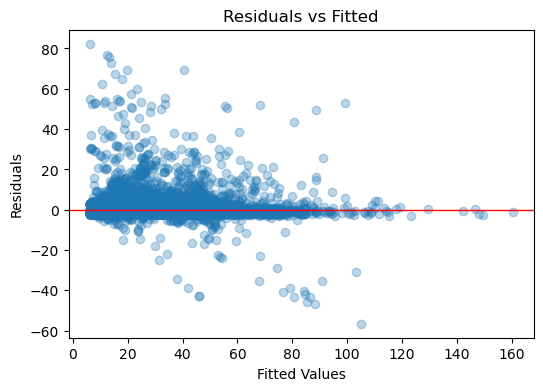

In [14]:
_, bp_pvalue, _, _ = het_breuschpagan(residuals, model.model.exog)
print(f"Breusch–Pagan p-value: {bp_pvalue:.5f}")

robust_model = model.get_robustcov_results(cov_type='HC3')
print(robust_model.summary())

plt.figure(figsize=(6, 4))
plt.scatter(model.fittedvalues, residuals, alpha=0.3)
plt.axhline(0, color='red', lw=1)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

## 10. Multi-Feature Model: Adding More Predictors

Enhance the model by adding multiple relevant features identified during exploration to improve prediction accuracy.

In [15]:
# Create multi-feature model using multiple relevant predictors
# Select additional features that were identified during exploration
multi_features = ['TRIP_MILES', 'TRIP_SECONDS', 'TRIP_START_HOUR']

# Create clean dataset with multiple features
df_multi = df.dropna(subset=multi_features + ['FARE'])
df_multi = df_multi[(df_multi['TRIP_MILES'] > 0) & (df_multi['FARE'] > 0)]

X_multi = df_multi[multi_features]
y_multi = df_multi['FARE']

# Add constant term
X_multi = sm.add_constant(X_multi)

# Split the data
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=0)

# Train multi-feature model
multi_model = sm.OLS(y_train_multi, X_train_multi).fit()

print("Multi-feature model summary:")
print(multi_model.summary())

Multi-feature model summary:
                            OLS Regression Results                            
Dep. Variable:                   FARE   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                 1.934e+05
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        00:47:36   Log-Likelihood:                -67542.
No. Observations:               25355   AIC:                         1.351e+05
Df Residuals:                   25351   BIC:                         1.351e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const        

## 11. Log-Transformed Model

Implement a log-transformed model to address non-normality and heteroscedasticity.

In [16]:
# Create log-transformed variables
df['log_TRIP_MILES'] = np.log(df['TRIP_MILES'] + 1)  # +1 to avoid log(0)
df['log_FARE'] = np.log1p(df['FARE'])

X_log = df[['log_TRIP_MILES']]
X_log = sm.add_constant(X_log)
y_log = df['log_FARE']

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=0)

log_model = sm.OLS(y_train_log, X_train_log).fit()

print(log_model.summary())

# Predictions in log scale, convert back
y_pred_log = log_model.predict(X_test_log)
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

log_mse = mean_squared_error(y_test_original, y_pred_original)
log_r2 = r2_score(y_test_original, y_pred_original)

print(f"MSE (original scale): {log_mse:.2f}")
print(f"R² (original scale): {log_r2:.4f}")

                            OLS Regression Results                            
Dep. Variable:               log_FARE   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 8.023e+05
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        00:47:40   Log-Likelihood:                 16128.
No. Observations:               25355   AIC:                        -3.225e+04
Df Residuals:                   25353   BIC:                        -3.224e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.4498      0.002    773.

---

# Lesson Tutorial

This section follows the Statsmodels Tutorial from the lesson addendum, using the Chicago taxi dataset for linear regression.

In [17]:
# Load the Chicago taxi dataset
df_taxi = pd.read_csv('../dataset/chicago_taxi_train.csv')
# Select relevant columns for linear regression
df_synth = df_taxi[['TRIP_MILES', 'FARE']].dropna()
# Rename columns to match the tutorial
df_synth = df_synth.rename(columns={'TRIP_MILES': 'X', 'FARE': 'y'})

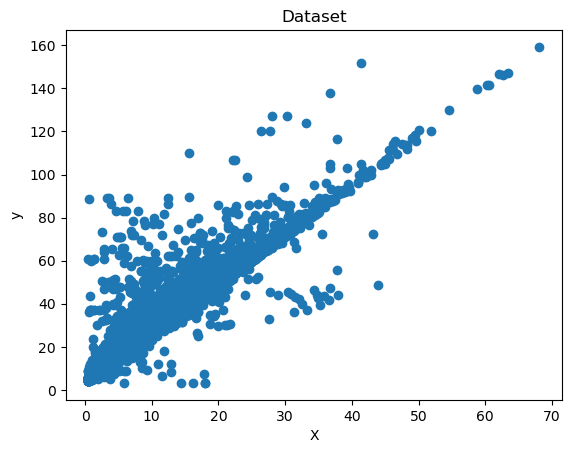

In [18]:
# It's often useful to visualize the data before building models.
plt.scatter(df_synth['X'], df_synth['y'])
plt.title('Dataset')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [19]:
X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(df_synth['X'], df_synth['y'], test_size=0.2, random_state=0)

In [20]:
X_train_synth = sm.add_constant(X_train_synth)
X_test_synth = sm.add_constant(X_test_synth)

In [21]:
model_synth = sm.OLS(y_train_synth, X_train_synth).fit()

In [22]:
print(model_synth.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 4.995e+05
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        00:47:56   Log-Likelihood:                -69354.
No. Observations:               25355   AIC:                         1.387e+05
Df Residuals:                   25353   BIC:                         1.387e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0281      0.036    141.398      0.0

In [23]:
# Use the model to make predictions on the test set.
y_pred_synth = model_synth.predict(X_test_synth)

In [24]:
# Evaluate the model's performance on the test set using metrics like Mean Squared Error (MSE) and R-squared.

mse_synth = mean_squared_error(y_test_synth, y_pred_synth)
r2_synth = r2_score(y_test_synth, y_pred_synth)

print("Mean Squared Error:", mse_synth)
print("R^2 Score:", r2_synth)

Mean Squared Error: 14.477537112737577
R^2 Score: 0.9497058070457518


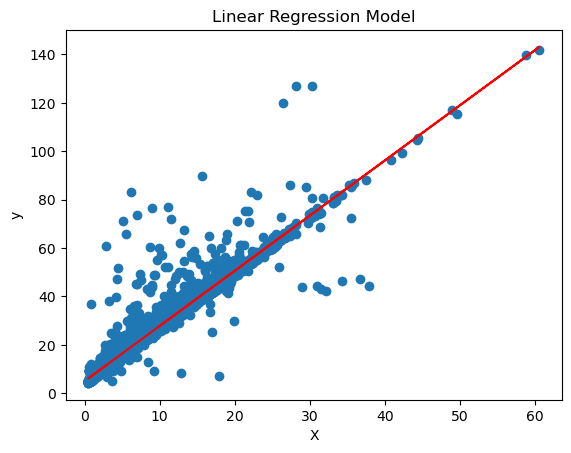

In [25]:
plt.scatter(X_test_synth['X'], y_test_synth)
plt.plot(X_test_synth['X'], y_pred_synth, color='red')
plt.title('Linear Regression Model')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

---

# Statsmodels Tutorial Notebook Version 2

This section demonstrates data-driven feature selection techniques without relying on domain knowledge. We'll use statistical methods and automated techniques to identify the best features for predicting taxi fares.

## Step 1: Define the Problem

Without domain knowledge, we want to predict taxi FARE using data-driven feature selection methods to identify the most predictive features.

In [38]:
# Load fresh dataset for data-driven analysis
df_v2 = pd.read_csv('../dataset/chicago_taxi_train.csv')

print("Dataset shape:", df_v2.shape)
print("\nNumerical columns available:")
numerical_cols_v2 = df_v2.select_dtypes(include=[np.number]).columns
print(numerical_cols_v2.tolist())

# Analyze potential target variables without domain bias
print("\n=== TARGET VARIABLE ANALYSIS ===")
for col in numerical_cols_v2:
    print(f"\n{col}:")
    print(f"  Range: {df_v2[col].min():.2f} to {df_v2[col].max():.2f}")
    print(f"  Mean: {df_v2[col].mean():.2f}")
    print(f"  Std: {df_v2[col].std():.2f}")
    print(f"  Missing: {df_v2[col].isnull().sum()}")
    print(f"  Zeros: {(df_v2[col] == 0).sum()}")
    print(f"  Coefficient of Variation: {df_v2[col].std()/df_v2[col].mean():.3f}")

Dataset shape: (31694, 18)

Numerical columns available:
['TRIP_START_HOUR', 'TRIP_SECONDS', 'TRIP_MILES', 'TRIP_SPEED', 'PICKUP_CENSUS_TRACT', 'DROPOFF_CENSUS_TRACT', 'PICKUP_COMMUNITY_AREA', 'DROPOFF_COMMUNITY_AREA', 'FARE', 'TIPS', 'TIP_RATE', 'TOLLS', 'EXTRAS', 'TRIP_TOTAL']

=== TARGET VARIABLE ANALYSIS ===

TRIP_START_HOUR:
  Range: 0.00 to 23.75
  Mean: 14.19
  Std: 5.16
  Missing: 0
  Zeros: 161
  Coefficient of Variation: 0.364

TRIP_SECONDS:
  Range: 60.00 to 7140.00
  Mean: 1319.80
  Std: 928.93
  Missing: 0
  Zeros: 0
  Coefficient of Variation: 0.704

TRIP_MILES:
  Range: 0.50 to 68.12
  Mean: 8.29
  Std: 7.27
  Missing: 0
  Zeros: 0
  Coefficient of Variation: 0.876

TRIP_SPEED:
  Range: 4.00 to 64.80
  Mean: 20.26
  Std: 11.11
  Missing: 0
  Zeros: 0
  Coefficient of Variation: 0.548

PICKUP_CENSUS_TRACT:
  Range: 17031020702.00 to 17031980100.00
  Mean: 17031532382.13
  Std: 382774.69
  Missing: 18435
  Zeros: 0
  Coefficient of Variation: 0.000

DROPOFF_CENSUS_TRACT:
 

In [39]:
# For this analysis, we want to predict FARE (taxi fare)
# The question is: which features best predict FARE without domain knowledge?
selected_target = 'FARE'

print(f"Target variable: {selected_target}")
print(f"Target statistics:")
print(f"  Range: {df_v2[selected_target].min():.2f} to {df_v2[selected_target].max():.2f}")
print(f"  Mean: {df_v2[selected_target].mean():.2f}")
print(f"  Std: {df_v2[selected_target].std():.2f}")
print(f"  Missing values: {df_v2[selected_target].isnull().sum()}")
print(f"  Non-zero values: {(df_v2[selected_target] > 0).sum()}")

print(f"\nObjective: Find the best features to predict {selected_target} using data-driven methods")

Target variable: FARE
Target statistics:
  Range: 3.25 to 159.25
  Mean: 23.91
  Std: 16.97
  Missing values: 0
  Non-zero values: 31694

Objective: Find the best features to predict FARE using data-driven methods


## Step 2: Correlation-Based Feature Analysis

Analyze correlations between all features and the selected target to identify potentially useful predictors.

In [40]:
# Calculate correlations between all numerical features and selected target
correlations = df_v2[numerical_cols_v2].corr()[selected_target].abs().sort_values(ascending=False)

print("Correlation with target variable (absolute values):")
print("=" * 50)
for feature, corr in correlations.items():
    if feature != selected_target:  # Exclude self-correlation
        print(f"{feature:25s}: {corr:.4f}")

# Select features with correlation > 0.1 (threshold can be adjusted)
correlation_threshold = 0.1
strong_features = correlations[correlations > correlation_threshold].drop(selected_target).index.tolist()

print(f"\nFeatures with |correlation| > {correlation_threshold}:")
print(strong_features)

Correlation with target variable (absolute values):
TRIP_MILES               : 0.9753
TRIP_TOTAL               : 0.9521
TRIP_SECONDS             : 0.8303
TRIP_SPEED               : 0.6957
PICKUP_CENSUS_TRACT      : 0.5865
PICKUP_COMMUNITY_AREA    : 0.5673
TIPS                     : 0.5447
EXTRAS                   : 0.4629
DROPOFF_COMMUNITY_AREA   : 0.2520
DROPOFF_CENSUS_TRACT     : 0.1591
TIP_RATE                 : 0.0710
TRIP_START_HOUR          : 0.0378
TOLLS                    : 0.0194

Features with |correlation| > 0.1:
['TRIP_MILES', 'TRIP_TOTAL', 'TRIP_SECONDS', 'TRIP_SPEED', 'PICKUP_CENSUS_TRACT', 'PICKUP_COMMUNITY_AREA', 'TIPS', 'EXTRAS', 'DROPOFF_COMMUNITY_AREA', 'DROPOFF_CENSUS_TRACT']


## Step 3: Univariate Feature Selection

Use statistical tests to select features based on their individual relationship with the target.

In [46]:
# Import required feature selection tools
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# Prepare data (remove missing values)
df_clean_v2 = df_v2.dropna()
X_all = df_clean_v2[numerical_cols_v2].drop(columns=[selected_target])
y_v2 = df_clean_v2[selected_target]

print("Clean data shape:", df_clean_v2.shape)
print("Features shape:", X_all.shape)
print("Target shape:", y_v2.shape)

# SelectKBest with f_regression (linear relationships)
selector_f = SelectKBest(score_func=f_regression, k=5)
X_selected_f = selector_f.fit_transform(X_all, y_v2)
selected_features_f = X_all.columns[selector_f.get_support()].tolist()

print("\nTop 5 features using F-regression:")
for i, feature in enumerate(selected_features_f):
    score = selector_f.scores_[list(X_all.columns).index(feature)]
    print(f"{feature:25s}: {score:.2f}")

# Mutual Information (non-linear relationships)
mi_scores = mutual_info_regression(X_all, y_v2)
mi_features = pd.Series(mi_scores, index=X_all.columns).sort_values(ascending=False)

print("\nTop 5 features using Mutual Information:")
for feature, score in mi_features.head().items():
    print(f"{feature:25s}: {score:.4f}")

Clean data shape: (12463, 18)
Features shape: (12463, 13)
Target shape: (12463,)

Top 5 features using F-regression:
TRIP_SECONDS             : 55833.45
TRIP_MILES               : 583053.07
TRIP_SPEED               : 22413.25
PICKUP_COMMUNITY_AREA    : 14185.89
TRIP_TOTAL               : 427447.87

Top 5 features using Mutual Information:
TRIP_TOTAL               : 2.4359
TRIP_MILES               : 1.9294
TRIP_SECONDS             : 1.3523
TIPS                     : 1.1485
TIP_RATE                 : 1.1308

Top 5 features using Mutual Information:
TRIP_TOTAL               : 2.4359
TRIP_MILES               : 1.9294
TRIP_SECONDS             : 1.3523
TIPS                     : 1.1485
TIP_RATE                 : 1.1308


## Step 4: Recursive Feature Elimination (RFE)

Use RFE with linear regression to iteratively select the most important features.

In [47]:
# Import RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Use RFE with LinearRegression to select top 3 features
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=3)
X_rfe = rfe.fit_transform(X_all, y_v2)
selected_features_rfe = X_all.columns[rfe.get_support()].tolist()

print("Features selected by RFE:")
for i, feature in enumerate(selected_features_rfe):
    ranking = rfe.ranking_[list(X_all.columns).index(feature)]
    print(f"{feature:25s}: Rank {ranking}")

# Show feature rankings
print("\nAll feature rankings (1=selected):")
feature_rankings = pd.Series(rfe.ranking_, index=X_all.columns).sort_values()
for feature, rank in feature_rankings.items():
    status = "SELECTED" if rank == 1 else f"Rank {rank}"
    print(f"{feature:25s}: {status}")

Features selected by RFE:
TIPS                     : Rank 1
EXTRAS                   : Rank 1
TRIP_TOTAL               : Rank 1

All feature rankings (1=selected):
TIPS                     : SELECTED
EXTRAS                   : SELECTED
TRIP_TOTAL               : SELECTED
TOLLS                    : Rank 2
TRIP_MILES               : Rank 3
TRIP_START_HOUR          : Rank 4
TIP_RATE                 : Rank 5
TRIP_SPEED               : Rank 6
PICKUP_COMMUNITY_AREA    : Rank 7
DROPOFF_COMMUNITY_AREA   : Rank 8
TRIP_SECONDS             : Rank 9
PICKUP_CENSUS_TRACT      : Rank 10
DROPOFF_CENSUS_TRACT     : Rank 11


## Step 5: Variance Inflation Factor (VIF) Analysis

Check for multicollinearity among selected features to ensure they're not redundant.

In [43]:
# Calculate VIF for RFE selected features
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Combine all selected features from different methods
all_selected = list(set(selected_features_f + selected_features_rfe + strong_features))
print("Combined selected features:", all_selected)

# Calculate VIF for these features
if len(all_selected) > 1:
    X_selected = df_clean_v2[all_selected]
    X_selected_const = sm.add_constant(X_selected)
    
    print("\nVariance Inflation Factor (VIF) Analysis:")
    print("=" * 45)
    vif_data = []
    for i, feature in enumerate(X_selected_const.columns):
        if feature != 'const':
            vif = variance_inflation_factor(X_selected_const.values, i)
            vif_data.append((feature, vif))
            status = "HIGH" if vif > 10 else "MODERATE" if vif > 5 else "LOW"
            print(f"{feature:25s}: {vif:.2f} ({status} multicollinearity)")
    
    # Remove high VIF features (>10)
    final_features = [feature for feature, vif in vif_data if vif <= 10]
    print(f"\nFinal features after VIF filtering (VIF ≤ 10): {final_features}")
else:
    final_features = all_selected
    print("Only one feature selected, skipping VIF analysis")

Combined selected features: ['TRIP_SPEED', 'TRIP_SECONDS', 'TRIP_TOTAL', 'DROPOFF_COMMUNITY_AREA', 'EXTRAS', 'DROPOFF_CENSUS_TRACT', 'PICKUP_COMMUNITY_AREA', 'TRIP_MILES', 'PICKUP_CENSUS_TRACT', 'TIPS']

Variance Inflation Factor (VIF) Analysis:
TRIP_SPEED               : 10.54 (HIGH multicollinearity)
TRIP_SECONDS             : 16.65 (HIGH multicollinearity)
TRIP_TOTAL               : 99.13 (HIGH multicollinearity)
DROPOFF_COMMUNITY_AREA   : 2.37 (LOW multicollinearity)
EXTRAS                   : 3.19 (LOW multicollinearity)
DROPOFF_CENSUS_TRACT     : 1.45 (LOW multicollinearity)
PICKUP_COMMUNITY_AREA    : 4.45 (LOW multicollinearity)
TRIP_MILES               : 72.17 (HIGH multicollinearity)
PICKUP_CENSUS_TRACT      : 1.79 (LOW multicollinearity)
TIPS                     : 6.08 (MODERATE multicollinearity)

Final features after VIF filtering (VIF ≤ 10): ['DROPOFF_COMMUNITY_AREA', 'EXTRAS', 'DROPOFF_CENSUS_TRACT', 'PICKUP_COMMUNITY_AREA', 'PICKUP_CENSUS_TRACT', 'TIPS']


## Step 6: Model Validation and Feature Performance

Train models with different feature sets and compare performance using cross-validation.

In [48]:
# Compare different feature sets using cross-validation
from sklearn.model_selection import cross_val_score

feature_sets = {
    'Top Correlation': strong_features[:3],  # Top 3 by correlation
    'F-regression': selected_features_f,
    'RFE': selected_features_rfe,
    'Final Selected': final_features
}

results = {}

print("Cross-Validation Results (R² scores):")
print("=" * 60)

for name, features in feature_sets.items():
    if len(features) > 0 and all(f in df_clean_v2.columns for f in features):
        X_subset = df_clean_v2[features]
        
        # 5-fold cross-validation
        cv_scores = cross_val_score(LinearRegression(), X_subset, y_v2, cv=5, scoring='r2')
        
        results[name] = {
            'features': features,
            'mean_r2': cv_scores.mean(),
            'std_r2': cv_scores.std(),
            'scores': cv_scores
        }
        
        print(f"{name:20s}: R² = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        print(f"{'':20s}  Features: {features}")
        print()

# Select best performing feature set
best_method = max(results, key=lambda x: results[x]['mean_r2'])
best_features = results[best_method]['features']

print(f"Best performing method: {best_method}")
print(f"Best features: {best_features}")
print(f"Best R² score: {results[best_method]['mean_r2']:.4f}")

Cross-Validation Results (R² scores):
Top Correlation     : R² = 0.9079 (±0.0619)
                      Features: ['TRIP_MILES', 'TRIP_TOTAL', 'TRIP_SECONDS']

F-regression        : R² = 0.9117 (±0.0624)
                      Features: ['TRIP_SECONDS', 'TRIP_MILES', 'TRIP_SPEED', 'PICKUP_COMMUNITY_AREA', 'TRIP_TOTAL']

RFE                 : R² = 0.9952 (±0.0039)
                      Features: ['TIPS', 'EXTRAS', 'TRIP_TOTAL']

Final Selected      : R² = -1.5566 (±1.7400)
                      Features: ['DROPOFF_COMMUNITY_AREA', 'EXTRAS', 'DROPOFF_CENSUS_TRACT', 'PICKUP_COMMUNITY_AREA', 'PICKUP_CENSUS_TRACT', 'TIPS']

Best performing method: RFE
Best features: ['TIPS', 'EXTRAS', 'TRIP_TOTAL']
Best R² score: 0.9952


## Step 7: Final Model with Data-Driven Selected Features

Train the final Statsmodels OLS regression using the best performing features identified through data-driven methods.

In [45]:
# Prepare final dataset with selected features
X_final = df_clean_v2[best_features]
y_final = df_clean_v2[selected_target]

# Train-test split
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42)

# Add constant for Statsmodels
X_train_final_const = sm.add_constant(X_train_final)
X_test_final_const = sm.add_constant(X_test_final)

# Train final OLS model
final_model_v2 = sm.OLS(y_train_final, X_train_final_const).fit()

print("Final Model Summary (Data-Driven Feature Selection):")
print("=" * 60)
print(final_model_v2.summary())

# Make predictions and evaluate
y_pred_final = final_model_v2.predict(X_test_final_const)
mse_final = mean_squared_error(y_test_final, y_pred_final)
r2_final = r2_score(y_test_final, y_pred_final)

print(f"\nFinal Model Performance:")
print(f"MSE: {mse_final:.4f}")
print(f"R²:  {r2_final:.4f}")
print(f"Selected Target: {selected_target}")
print(f"Selected Features: {best_features}")
print(f"Feature Selection Method: {best_method}")

Final Model Summary (Data-Driven Feature Selection):
                            OLS Regression Results                            
Dep. Variable:                   FARE   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.091e+06
Date:                Mon, 22 Sep 2025   Prob (F-statistic):               0.00
Time:                        01:10:13   Log-Likelihood:                -3793.1
No. Observations:                9970   AIC:                             7594.
Df Residuals:                    9966   BIC:                             7623.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------